# Proto-historic navigation performance data: exploratory work
> Author: Matteo Tomasini

In this script I simply explore a few concepts to attempt to explore data. This notebook helps me also test snippets of code that are then transferred to the `processing.py` and `plotting.py` files.

For each transect marked in the recording sheets, I want to output average speed over the transect (possibly with some measure of variance), as well as a polar diagram with the angle kept by the boat. We can also match this with paddling frequency and weight of the vessel. 

The table should be formatted as (_e.g._):

| Vessel | Day, times | Location, Sea conditions | Avg speed (std) [m/s] | Avg angle (std) [deg] | Estimated bearing in degrees [deg] | Crew | Frequency |
---------|------------|----------------|------------------------|----------------------------|------------------------------|------|-----------|
| Logboat 6.5 | 05.09.2023, 14:38 - 15:03 | Aber Wrac'h, small waves | 3.2 (0.7) | 221 (4) | 219 | 3 people | 45 |

## Pipeline

For each trial in paper sheet:
1) show trajectory
2) pick segment to analyze (between two straight points) = find coordinates + times of start and end
3) record day, start time, end time, crew, frequency, location, sea conditions -> in sheet
4) automatize calculations
    - from start time and end time, calculate speed, angle
    - update sheet with automatized data

Points 1), 2) and 3) are done my hand. Point 4) takes all the points from a `.csv` and completes the table.

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import movingpandas
from processing import coordinate_conversion
from plotting import cut_transect, plot_trajectory, plot_direction, plot_towing, plot_towing_by_weight, plot_towing_by_orientation
from datetime import datetime, timedelta
import hvplot.pandas
from holoviews import opts, dim
import cartopy
import datetime
import math


import warnings
warnings.filterwarnings('ignore')

In [53]:
#full_data_1 = pd.read_csv("./CSV_Data/000000_013.n2kdecoded.csv", encoding='windows-1252')
#full_data_2 = pd.read_csv("./CSV_Data/000000_014.n2kdecoded.csv", encoding='windows-1252')
#full_data = pd.concat([full_data_1, full_data_2], ignore_index=True)
full_data = pd.read_csv("./CSV_Data/23Aug07-10/20230807_big_box.csv", encoding="windows-1252")
full_data["Name"].unique()



array(['Wind Data', 'Vessel Heading', 'Speed, Water Referenced',
       'COG & SOG, Rapid Update', 'Position, Rapid Update',
       'GNSS Position Data'], dtype=object)

In [54]:
# Add to processing to split data. dropna is there to drop all columns not pertaining to that type of data
vessel_heading_raw = full_data[full_data["Name"] == "Vessel Heading"].dropna(axis=1)
speed_water_ref = full_data[full_data["Name"] == "Speed, Water Referenced"].dropna(axis=1)
position = full_data[full_data["Name"] == "Position, Rapid Update"].dropna(axis=1)
wind_data = full_data[full_data["Name"] == "Wind Data"].dropna(axis=1)
cog_sog = full_data[full_data["Name"] == "COG & SOG, Rapid Update"].dropna(axis=1)

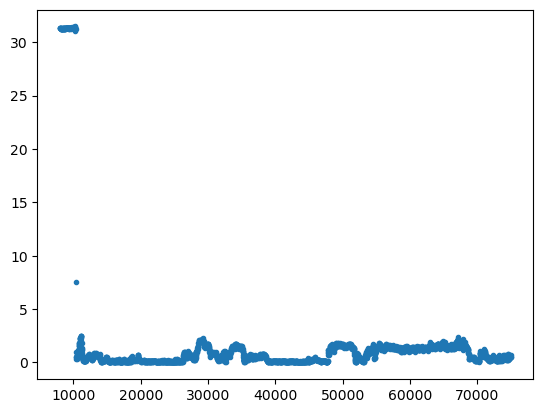

In [25]:
plt.plot(speed_water_ref["Speed Water Referenced"].loc[8000:75000], '.')

In [26]:
position['Converted Lat'] = position['Latitude'].apply(lambda x: coordinate_conversion(x))
position['Converted Lon'] = position['Longitude'].apply(lambda x: coordinate_conversion(x))
position['Converted Time'] = position['Time'].apply(lambda x: pd.to_datetime(x))

In [27]:
position_stripped = position[['Converted Time', 'Converted Lat', 'Converted Lon']]

In [28]:
trajectories = movingpandas.Trajectory(position_stripped, traj_id = 'logboat', t='Converted Time', x='Converted Lon', y='Converted Lat', crs="EPSG:4326")
trajectories = movingpandas.MinTimeDeltaGeneralizer(trajectories).generalize(tolerance=timedelta(seconds=5))

In [29]:
# plot_defaults = {'linewidth':5, 'capstyle':'round', 'figsize':(9,3), 'legend':True}
opts.defaults(opts.Overlay(active_tools=['wheel_zoom'], frame_width=500, frame_height=500))
hvplot_defaults = {'cmap':'Viridis', 'colorbar':True, 'figsize':(5,4)}

In [30]:
plot_trajectory(position, with_speed=True, seconds_binning=5)

Launching server at http://localhost:46519


In [50]:
position['Time'].iloc[-1]

'10:15:26.089'

In [10]:
position[position['Time'].str.contains('13:30:00')]['Converted Lat']

37502    48.605099
Name: Converted Lat, dtype: float64

37502    48.605099
Name: Converted Lat, dtype: float64

## Segment selection and analysis

We need to build functions to select a segment and analyze:
1) speed
2) bearing angle 
3) additional aspects (frequency?)

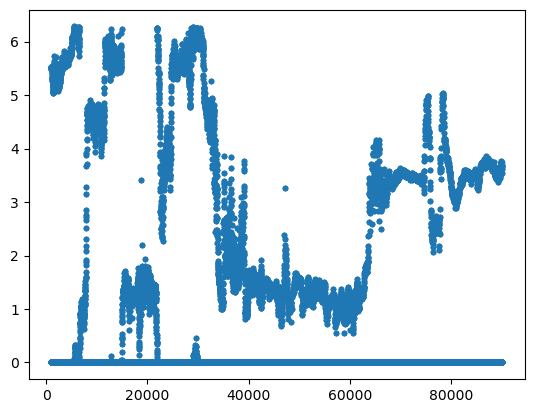

In [11]:
# plt.plot(speed_water_ref["Speed Water Referenced"].loc[8000:75000], '.')
plt.plot(vessel_heading_raw['Heading Sensor Reading'].loc[1000:90000], '.')

In [31]:
vessel_heading = vessel_heading_raw.loc[vessel_heading_raw["Heading Sensor Reading"]!=0]
# vessel_heading.drop(vessel_heading["Heading Sensor Reading"] == 0.0, axis=1)

In [32]:

vessel_heading["Heading (degrees)"] = vessel_heading.apply(lambda row: math.degrees(row["Heading Sensor Reading"]), axis=1)

vessel_heading["Time (coded)"] = vessel_heading.apply(lambda row: datetime.datetime.strptime(row["Time"], '%H:%M:%S.%f'), axis=1)


In [33]:
transect = vessel_heading.loc[50000:60000]
# length = len(transect) - 1 
indexes_ticks = [0, len(transect) // 5, 2*len(transect) // 5, 3*len(transect) // 5, 4*len(transect) // 5, len(transect)-1]
indexes_ticks
# transect["Time"].iloc[indexes_ticks].values

[0, 357, 715, 1072, 1430, 1787]

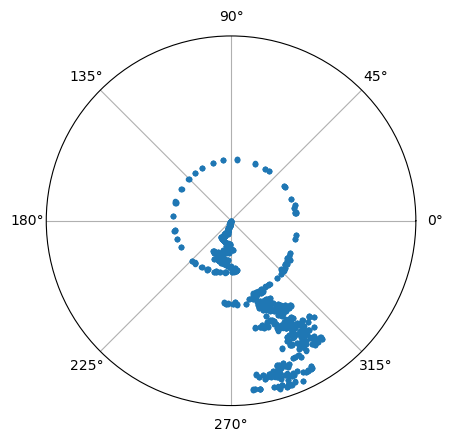

In [34]:

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.set_rticks(transect["Time"].iloc[indexes_ticks].index, label=transect["Time"].iloc[indexes_ticks].values)
# ax.
ax.plot(transect["Heading Sensor Reading"], range(0, transect.shape[0]), '.')


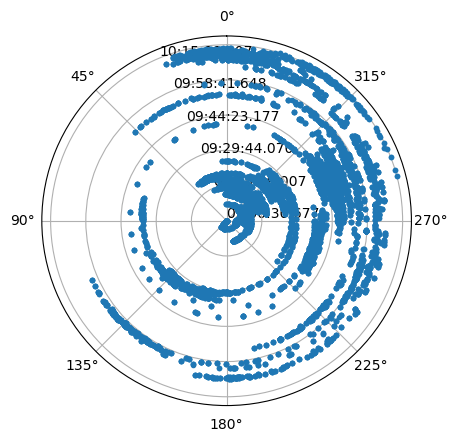

In [51]:
transect = cut_transect(vessel_heading, "09:00:30", '10:15:00')

indexes_ticks = [0, len(transect) // 5, 2*len(transect) // 5, 3*len(transect) // 5, 4*len(transect) // 5, len(transect)-1]

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(transect["Heading Sensor Reading"], range(0, transect.shape[0]), '.')
ax.set_rticks(indexes_ticks)
ax.set_yticklabels(transect["Time"].iloc[indexes_ticks].values)
ax.set_theta_zero_location('N')

In [35]:
number_of_ticks = 5
transect_size = len(transect)
for i in range(1, number_of_ticks + 1):
    tick = i * transect_size // number_of_ticks
    indexes_ticks.append(tick)
    
indexes_ticks

[0, 357, 715, 1072, 1430, 1787, 357, 715, 1072, 1430, 1788]

### Speed in water / difference with speed GPS

In [80]:
speed_water_ref = full_data[full_data["Name"] == "Speed, Water Referenced"].dropna(axis=1)
cog_sog = full_data[full_data["Name"] == "COG & SOG, Rapid Update"].dropna(axis=1)

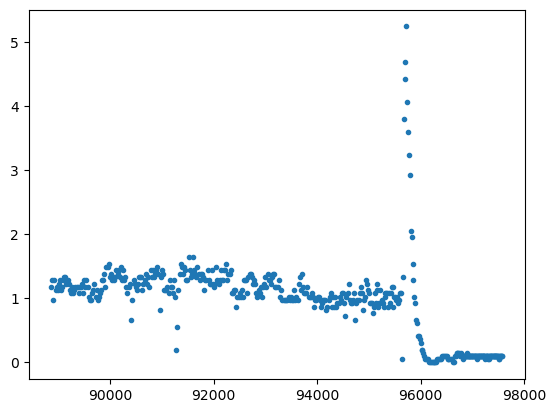

In [64]:
# plt.plot(speed_water_ref["Speed Water Referenced"].loc[8000:75000], '.')
start_time = "10:07:"
end_time = "10:14:"

speed_water_ref_transect = cut_transect(speed_water_ref, start_time, end_time)

plt.plot(speed_water_ref_transect["Speed Water Referenced"], '.')

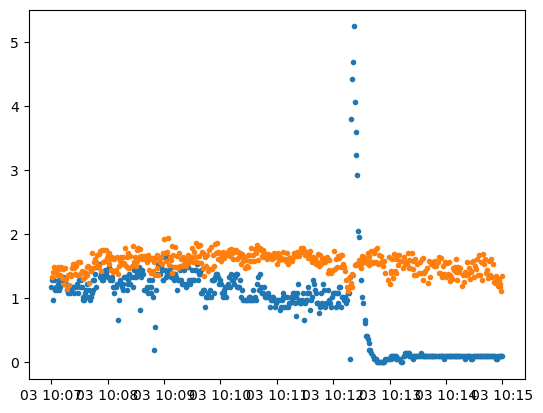

In [81]:
cog_sog_transect = cut_transect(cog_sog, start_time, end_time)
speed_water_ref_transect['Converted Time'] = speed_water_ref_transect['Time'].apply(lambda x: pd.to_datetime(x))
cog_sog_transect['Converted Time'] = cog_sog_transect['Time'].apply(lambda x: pd.to_datetime(x))

#position['Converted Time'] = position['Time'].apply(lambda x: pd.to_datetime(x))

plt.plot(speed_water_ref_transect["Converted Time"], speed_water_ref_transect["Speed Water Referenced"], '.')
plt.plot(cog_sog_transect["Converted Time"], cog_sog_transect["Speed Over Ground"], '.')

In [94]:
# new_cog = cog_sog_transect.pivot(index="Converted Time", columns="Speed Over Ground")
new_cog = cog_sog_transect.set_index("Converted Time")
new_speed = speed_water_ref_transect.set_index("Converted Time")
uniform_cog = new_cog.resample("s").max()
uniform_speed = new_speed.resample("s").max()

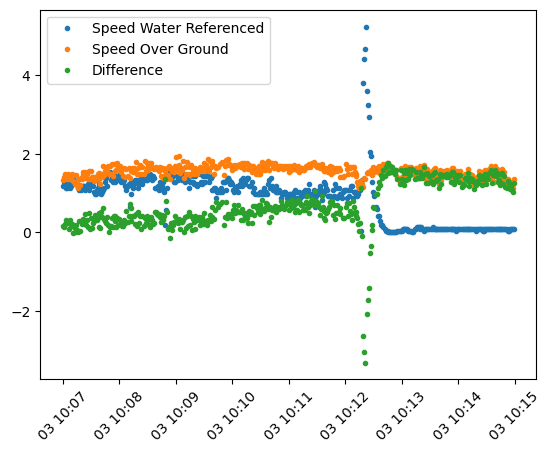

In [110]:
plt.plot(uniform_speed["Speed Water Referenced"], '.')
plt.plot(uniform_cog["Speed Over Ground"], '.')
plt.plot(uniform_cog["Speed Over Ground"] - uniform_speed["Speed Water Referenced"], '.')
plt.xticks(rotation=45, ha='center')
plt.legend(["Speed Water Referenced", "Speed Over Ground", "Difference"])

## Towing tests


In [36]:
towing_data = pd.read_excel("towing_data.ods", engine="odf", header=0)
towing_data

,trial,date,no_people,orientation,speed,force,weight,boat
0,1,2023-08-09,2,Lateral,1.5,40,303,Enora
1,1,2023-08-09,2,Lateral,1.8,40,303,Enora
2,1,2023-08-09,2,Lateral,2.8,100,303,Enora
3,1,2023-08-09,2,Lateral,4.0,500,303,Enora
4,2,2023-08-09,3,Lateral,1.5,40,380,Enora
...,...,...,...,...,...,...,...,...
70,5,2023-09-27,4,Straight,4.0,142,751,Logboat7.5
71,6,2023-09-27,2,Straight,1.6,34,572,Logboat7.5
72,6,2023-09-27,2,Straight,2.2,56,572,Logboat7.5
73,6,2023-09-27,2,Straight,3.3,70,572,Logboat7.5


In [19]:
boats = ["Enora", "Logboat6.5", "Logboat7.5"]
orientations = ["Straight", "Lateral"]
people_combinations = [1,2,3,4,6]

# plt.subplots(4, 4)


for boat in boats:
    for orientation in orientations:
        for number_of_people in people_combinations:
            # print(boat, orientation, number_of_people)
            try:
                plot_towing(towing_data, boat, orientation, number_of_people, save=True)
                plt.clf()
            except:
                print("Number of people not found!")

Number of people not found!
Number of people not found!
Number of people not found!
Number of people not found!
Number of people not found!
Number of people not found!
Number of people not found!
Number of people not found!
Number of people not found!
Number of people not found!
Number of people not found!
Number of people not found!


<Figure size 640x480 with 0 Axes>

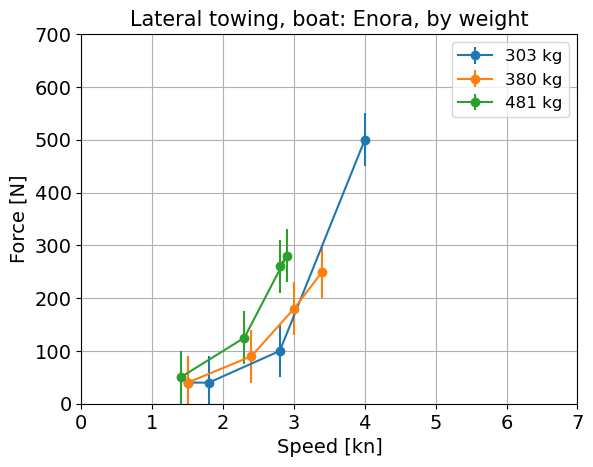

In [20]:
plot_towing_by_weight(towing_data, "Enora", "Lateral")

In [21]:
boats = ["Enora", "Logboat6.5", "Logboat7.5"]
orientations = ["Straight", "Lateral"]

for boat in boats:
    for orientation in orientations:
        plot_towing_by_weight(towing_data, boat, orientation, save=True)
        plt.clf()

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [4]:
boats = ["Enora", "Logboat6.5", "Logboat7.5"]
people = [1, 2, 3, 4, 6]

for boat in boats:
    for number_of_people in people:
        try:
            plot_towing_by_orientation(towing_data, boat, number_of_people, save=True)
            plt.clf()
        except:
            print("Number of people not found!")

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
plot_towing_by_orientation(towing_data, boat, orientation, save=True)

In [5]:
towing_data.to_csv("towing_data.csv", header=True, index=False)